This is the Notebook for the Araya coding work. All steps should be annotated for easy following. Any questions please contact Author.
I first carry out all imports. 
I get the Motor Imagery Dataset (BCI Competition IV Dataset 2a). I pre-process it as I see fit. 

I vizualise the data where i can to see what is happening/ make sure everything makes sense.
Then i do a train test split and try different classification techniques.
 
I test a few decoding possibilities to pick which I will use for the online decoding. 
 - simple logistic regretion 
 - liniar discriminat analysis
 - DL
 
At the end I create server that streams the EEG dataset using LSL 
i get the client side that does online decoding with my model of choice 

In [2]:
import time

from pylsl import StreamInfo, StreamOutlet

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from mne.decoding import CSP


import mne
from mne.datasets import eegbci #dataset of choice for challenge 
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import Vectorizer, FilterEstimator

from mne_realtime import StimServer
from mne_realtime import MockRtClient

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim


C:\Users\isabe\AppData\Local\Temp\ipykernel_36792\1549371243.py:25: FutureWarning: MNE-realtime is discontinued in favor of the Lab Streaming Layer real-time interface availabe in MNE-lsl: https://mne.tools/mne-lsl/
  from mne_realtime import StimServer


In [28]:
#get mne dataset (raw)
raw_fnames =eegbci.load_data(1, [6,10,14])# hands vs feet  
raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raws)

Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [29]:
#pre-processing
#filter raw data (8Hz,30Hz)
filtered_raw_data = raw.copy().filter(l_freq=0.1, h_freq=35, fir_design='firwin')
# raw_data.plot(title='no filter raw data')
# filtered_raw_data.plot(title='filtered data')
raw_data = filtered_raw_data
del filtered_raw_data
raw_data.rename_channels(lambda x: x.strip('.'))

# resample the data to 100Hz
raw_data.resample(sfreq=100)
print(raw_data.info)##

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 35.00 Hz


- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5281 samples (33.006 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


<Info | 8 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
 subject_info: 3 items (dict)
>


In [30]:
from mne.channels import make_standard_montage

# Set channel names
eegbci.standardize(raw_data)
montage = make_standard_montage('standard_1005')
raw_data.set_montage(montage)
print(raw_data.info)

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
 subject_info: 3 items (dict)
>


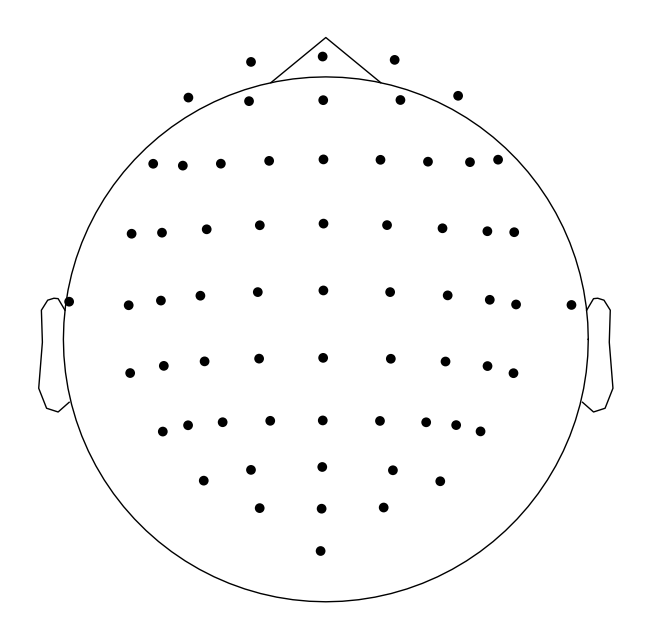

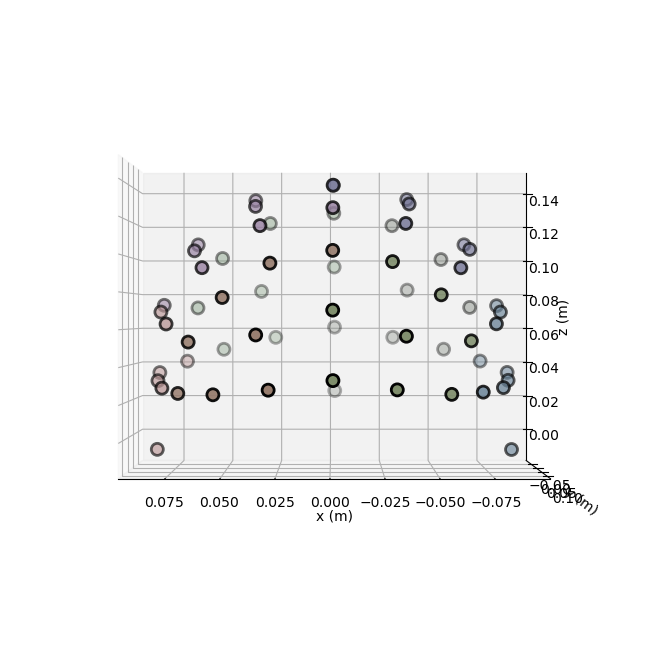

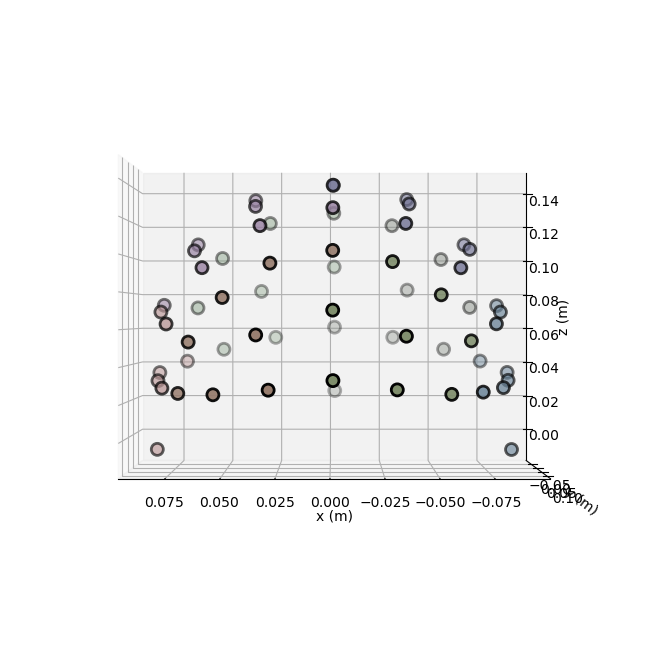

In [31]:
# Some visualisation 
raw_data.plot_sensors(ch_type='eeg')
raw_data.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


c:\Users\isabe\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


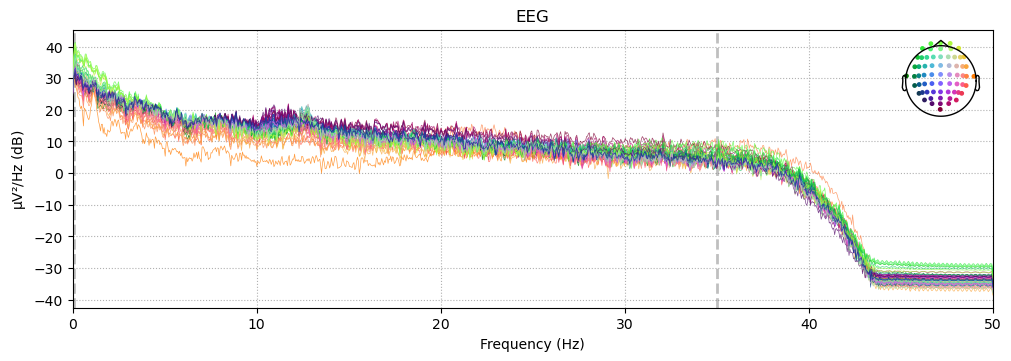

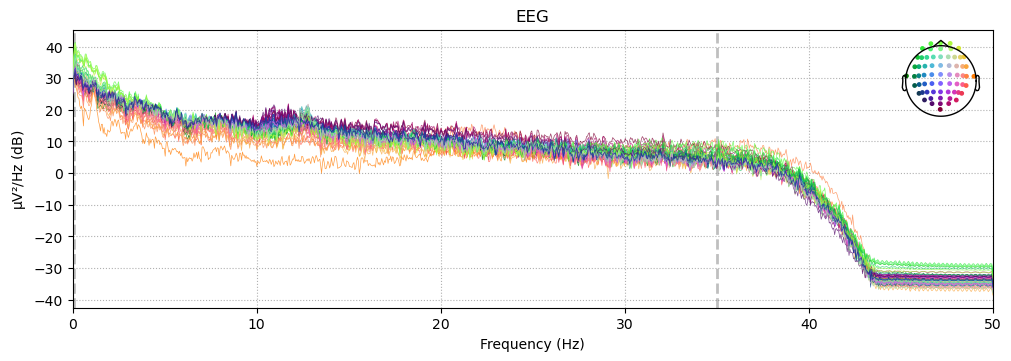

In [32]:
# plotting power specrum 
raw_data.plot_psd()

In [33]:
from mne import pick_types

# Select EEG channels
picks = pick_types(raw_data.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')

In [34]:
from mne import Epochs, events_from_annotations
raw=raw_data
# the timing is hard to pick... Could avoied evoked response starting at 1... 
tmin, tmax = -1, 4
event_id=dict(hands=2, feet=3)

# Get events from an Annotations object.
events, events_dict = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
print('Found {} events'.format(events.shape[0]))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done first with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)

# Inspect epochs
print(epochs.info)
print('events x channels x samples:', epochs._data.shape)

# Get labels
labels = epochs.events[:, -1] - 2

Used Annotations descriptions: ['T1', 'T2']
Found 45 events
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 501 original time points ...
0 bad epochs dropped
<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
 subject_info: 3 items (dict)
>
events x channels x samples: (45, 64, 501)


annotation info: <Annotations | 94 segments: BAD boundary (2), EDGE boundary (2), T0 (45), ...>
annotation duration:  [4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2]
annotation description:  {'EDGE boundary', 'T2', 'T1', 'BAD boundary', 'T0'}
events:  [[ 420    0    3]
 [1250    0    2]
 [2080    0    2]
 [2910    0    3]
 [3740    0    2]]
event dict:  {'T1': 2, 'T2': 3}


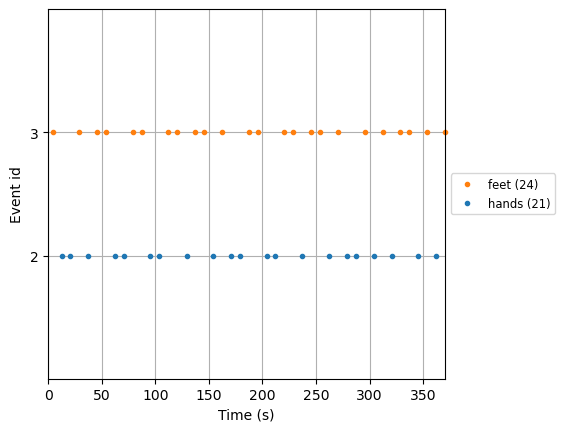

In [35]:
# check events 

# get the annotations(events) from raw data
print("annotation info:", raw_data.annotations)
print("annotation duration: ", raw_data.annotations.duration[:9])
print("annotation description: ", set(raw_data.annotations.description))


print("events: ", events[:5])
print("event dict: ", events_dict)
# event_dict is default to int from [1,n] n is the number of events

# visual the event distributed
events_fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'], first_samp=raw_data.first_samp, event_id=event_id)


Effective window size : 20.480 (s)


c:\Users\isabe\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\isabe\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


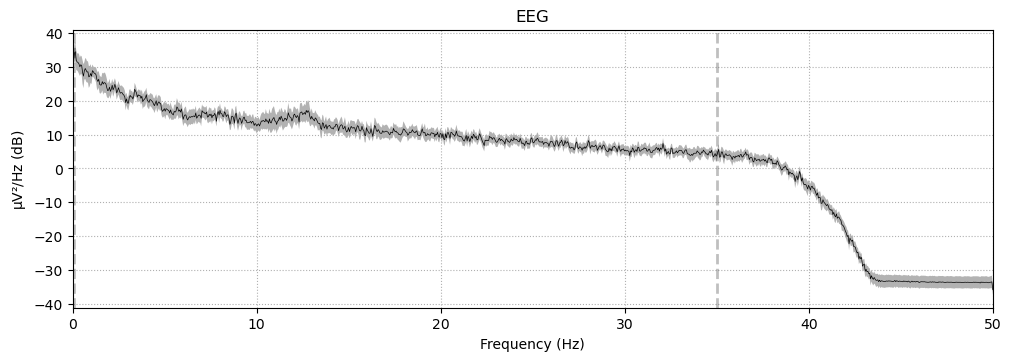

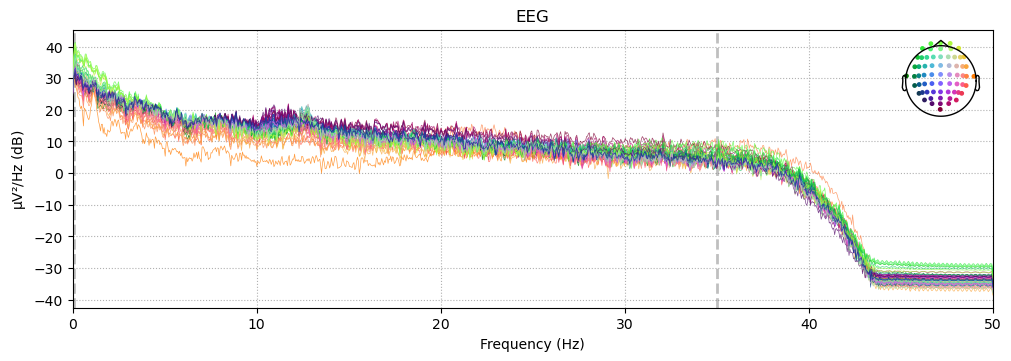

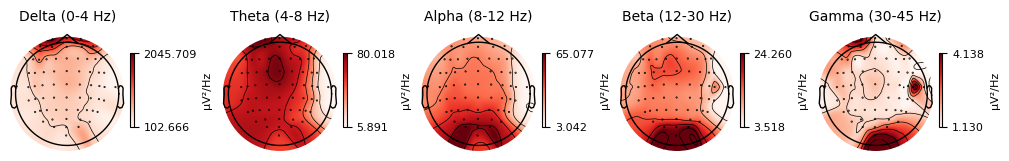

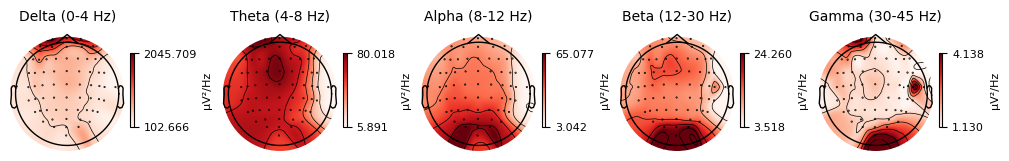

In [36]:
%matplotlib inline
# psd figure
spectrum = raw_data.compute_psd()
spectrum.plot(average=True)

# plot all channel
spectrum.plot()

# scalp topography
spectrum.plot_topomap()


Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


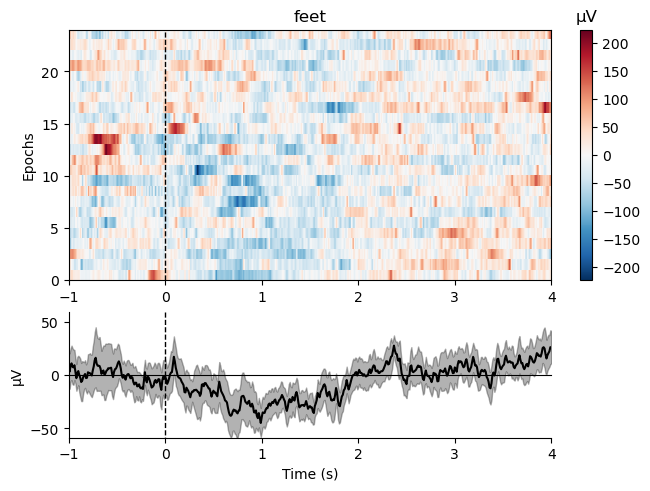

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


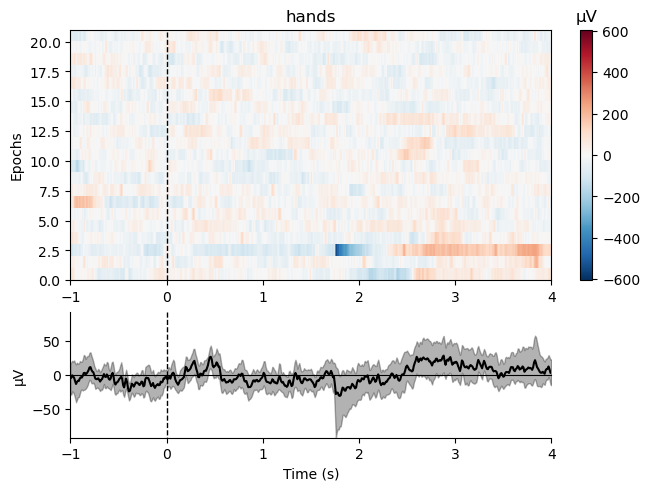

[<Figure size 640x480 with 3 Axes>]

In [37]:
# visualize the average epochs fig for 2 classes
epochs['feet'].plot_image(title='feet', combine='mean')
epochs['hands'].plot_image(title='hands', combine='mean')

In [38]:

# Prepare features and labels
X = epochs.get_data()  # EEG data
y = epochs.events[:, -1]  # Event labels (feet vs hands)

print(labels)


[1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 1 0 1]


C:\Users\isabe\AppData\Local\Temp\ipykernel_36792\3256665225.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()  # EEG data


combining channels using "gfp"
combining channels using "gfp"


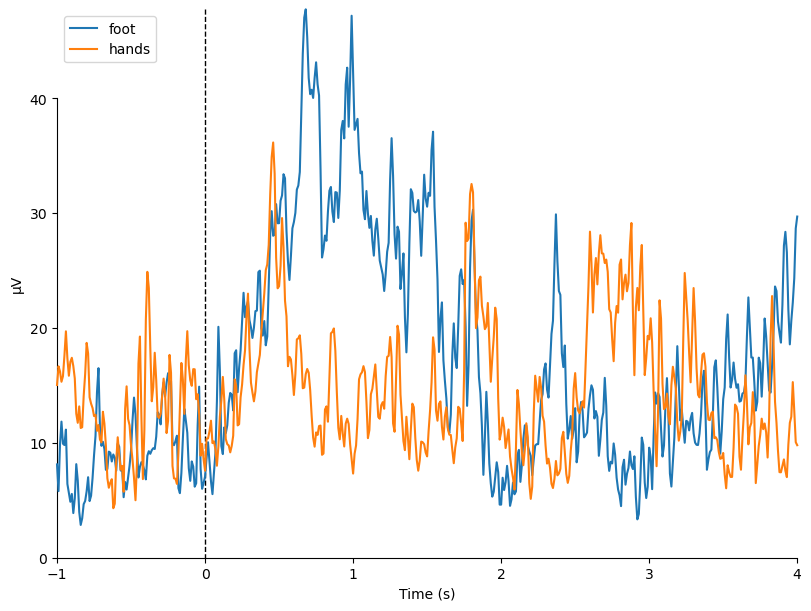

[<Figure size 800x600 with 1 Axes>]

In [39]:
#plot the evoked fig
evoked_dict = {'foot': epochs['feet'].average(), 'hands': epochs['hands'].average()}
mne.viz.plot_compare_evokeds(evoked_dict)

Now We have the data set up, I will carry out different classifications to then pick the prefered pipeline

In [40]:
# start simple with a K-fold cross validation 
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#epochs_data = 1e6 * epochs.get_data()

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, X, labels, cv=cv, n_jobs=1)

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" 
                                  % (np.mean(scores), class_balance))

Computing rank from data with rank=None


    Using tolerance 0.00058 (2.2e-16 eps * 64 dim * 4.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00051 (2.2e-16 eps * 64 dim * 3.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00045 (2.2e-16 eps * 64 dim * 3.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00055 (2.2e-16 eps * 64 dim * 3.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: ra

Computing rank from data with rank=None


    Using tolerance 0.0006 (2.2e-16 eps * 64 dim * 4.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00056 (2.2e-16 eps * 64 dim * 3.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


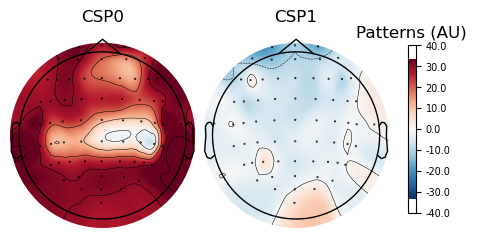

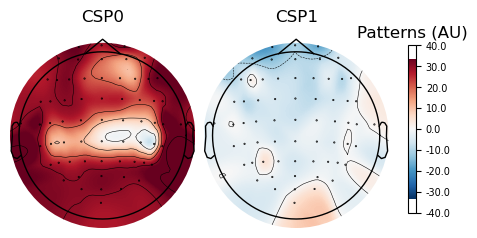

In [41]:

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(X, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

The results from the classification are terrible and I am not sure why. I believed it would be easier to classify hands and feet (???). So I will attempt some DL architectures from here.

In [42]:
#normalizes dataset so every EEG channel has a mean of 0 and standard deviation of 1 across all examples.
def setNorm(dataset):
    for i in range(dataset.shape[1]):
        channelMeans = dataset[:,i,:].mean()
        channelStdDev = dataset[:,i,:].std()
        dataset[:,i,:] = (dataset[:,i,:] - channelMeans)/channelStdDev
    return dataset

In [43]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

#Normalise
X=setNorm(X)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_train_tensor=F.one_hot(y_train_tensor, num_classes=2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [51]:
num_channels =64 
class NNet(nn.Module):
    def __init__(self, in_channels=num_channels, out_channels=2):
        super(NNet, self).__init__()
        self.hidden = 64
        self.net = nn.Sequential(
            nn.Conv1d(num_channels, num_channels, 3, padding=2),
            nn.Conv1d(self.hidden, self.hidden, 4, stride=1),  # Adjust
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 5 , padding=2),
        )
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final',# nn.Sequential( nn.Conv1d(self.hidden, out_channels, 1),
            #nn.Sigmoid()
                            nn.Conv1d(self.hidden, out_channels,1))
        
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, x):
        print("Input size:", x.size())
        x = self.net[0](x)
        print("After first convolution:", x.size())
        x = self.net[1](x)
        print("After second convolution:", x.size())
        x = self.net[2](x)
        print("After activation:", x.size())
        x = self.net[3](x)
        print("After third convolution:", x.size())
        
        for i in range(4, len(self.net)):
            x = self.net[i](x)
            print("After block {}: {}".format(i-4, x.size()))
        
        print("Final output size:", x.size())
     #
        

        return x


In [55]:
from tqdm.notebook import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_epochs=200 #50

nnet = NNet()
nnet.to(device)
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(), lr=0.0005, betas=(0.25, 0.75))
loss_his, train_loss = [], []
nnet.train()
for epoch in range(num_epochs):
    p_bar = tqdm(train_dataloader)
    for i, (x, y) in enumerate(p_bar):
        x, y = x.to(device), y.to(device)
        y = y.unsqueeze(-1)  # Add a new dimension at the end
        y = y.repeat(1, 1, 7)  
        y = y.float()
 
        pred = torch.sigmoid(nnet(x))
        loss = loss_fnc(pred.squeeze(dim=-1), y)
        adam.zero_grad()
        loss.backward()
        adam.step()
        train_loss.append(loss.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, num_epochs, loss_his[-1]))

  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 1/50] [Loss: 0.7040047645568848]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 2/50] [Loss: 0.7031217217445374]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 3/50] [Loss: 0.7022597193717957]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 4/50] [Loss: 0.7014049291610718]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 5/50] [Loss: 0.7004250288009644]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 6/50] [Loss: 0.6992425918579102]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 7/50] [Loss: 0.6971758008003235]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 8/50] [Loss: 0.6900702118873596]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 9/50] [Loss: 0.660641610622406]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 10/50] [Loss: 0.8562880754470825]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 11/50] [Loss: 0.6592170000076294]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 12/50] [Loss: 0.6670393347740173]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 13/50] [Loss: 0.6693621873855591]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 14/50] [Loss: 0.6632165908813477]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 15/50] [Loss: 0.6591011881828308]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 16/50] [Loss: 0.6552760004997253]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 17/50] [Loss: 0.651817262172699]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 18/50] [Loss: 0.6428517699241638]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 19/50] [Loss: 0.6452997326850891]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 20/50] [Loss: 0.6429701447486877]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 21/50] [Loss: 0.6369996666908264]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 22/50] [Loss: 0.6316601634025574]


  0%|          | 0/1 [00:01<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 23/50] [Loss: 0.6261476874351501]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 24/50] [Loss: 0.6151177287101746]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 25/50] [Loss: 0.6099140644073486]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 26/50] [Loss: 0.6133109331130981]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 27/50] [Loss: 0.6856251955032349]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 28/50] [Loss: 0.6099212765693665]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 29/50] [Loss: 0.5693928599357605]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 30/50] [Loss: 0.5604413747787476]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 31/50] [Loss: 0.5508267283439636]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 32/50] [Loss: 0.5404713153839111]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 33/50] [Loss: 0.7072121500968933]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 34/50] [Loss: 0.5367010235786438]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 35/50] [Loss: 0.5347374081611633]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 36/50] [Loss: 0.5155508518218994]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 37/50] [Loss: 0.5134928226470947]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 38/50] [Loss: 0.5465702414512634]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 39/50] [Loss: 0.5514472126960754]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 40/50] [Loss: 0.607929527759552]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 41/50] [Loss: 0.5023837685585022]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 42/50] [Loss: 0.5004867315292358]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 43/50] [Loss: 0.48386985063552856]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 44/50] [Loss: 0.4424114227294922]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 45/50] [Loss: 0.45319512486457825]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 46/50] [Loss: 0.5805138349533081]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 47/50] [Loss: 0.5195958614349365]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 48/50] [Loss: 0.4647960364818573]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 49/50] [Loss: 0.4077834486961365]


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([36, 64, 501])
After first convolution: torch.Size([36, 64, 503])
After second convolution: torch.Size([36, 64, 500])
After activation: torch.Size([36, 64, 500])
After third convolution: torch.Size([36, 64, 500])
After block 0: torch.Size([36, 64, 250])
After block 1: torch.Size([36, 64, 125])
After block 2: torch.Size([36, 64, 62])
After block 3: torch.Size([36, 64, 31])
After block 4: torch.Size([36, 64, 15])
After block 5: torch.Size([36, 64, 7])
After block 6: torch.Size([36, 2, 7])
Final output size: torch.Size([36, 2, 7])
[Epoch 50/50] [Loss: 0.3754439055919647]


In [27]:
#test 
nnet.eval()
y_pred = []
with torch.no_grad():
    for x, _ in tqdm(test_dataloader):
        x = x.to(device)
        pred = torch.sigmoid(nnet(x).detach().cpu()).numpy()
        y_pred.append(pred)


  0%|          | 0/1 [00:00<?, ?it/s]

Input size: torch.Size([9, 64, 501])
After first convolution: torch.Size([9, 64, 503])
After second convolution: torch.Size([9, 64, 500])
After activation: torch.Size([9, 64, 500])
After third convolution: torch.Size([9, 64, 502])
After block 0: torch.Size([9, 64, 251])
After block 1: torch.Size([9, 64, 125])
After block 2: torch.Size([9, 64, 62])
After block 3: torch.Size([9, 64, 31])
After block 4: torch.Size([9, 64, 15])
After block 5: torch.Size([9, 64, 7])
After block 6: torch.Size([9, 2, 7])
Final output size: torch.Size([9, 2, 7])


unfortunetly with the time i had, I didn't manage to get a better DL model. But I hyope this notebook provided my rationale in tackling the decoding problem in a easy to follow manner  

In [56]:
# Server Side --sending 

import sys
import getopt

import time
from random import random as rand

from pylsl import StreamInfo, StreamOutlet, local_clock


def main(argv):
    srate = 160
    name = 'MotorImageryStream'
    type = 'EEG'
    n_channels = 64
    help_string = 'SendData.py -s <sampling_rate> -n <stream_name> -t <stream_type>'
    try:
        opts, args = getopt.getopt(argv, "hs:c:n:t:", longopts=["srate=", "channels=", "name=", "type"])
    except getopt.GetoptError:
        print(help_string)
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print(help_string)
            sys.exit()
        elif opt in ("-s", "--srate"):
            srate = float(arg)
        elif opt in ("-c", "--channels"):
            n_channels = int(arg)
        elif opt in ("-n", "--name"):
            name = arg
        elif opt in ("-t", "--type"):
            type = arg

    # last value would be the serial number of the device or some other more or
    # less locally unique identifier for the stream as far as available 
    info = StreamInfo(name, type, n_channels, srate, 'float32', 'myuid34234')

    # next make an outlet
    outlet = StreamOutlet(info)

    print("now sending data...")
    start_time = local_clock()
    sent_samples = 0
    while True:
        elapsed_time = local_clock() - start_time
        required_samples = int(srate * elapsed_time) - sent_samples
        for sample_ix in range(required_samples):
            # make a new random n_channels sample; this is converted into a
            # pylsl.vectorf (the data type that is expected by push_sample)
            mysample = X_test
            # now send it
            outlet.push_sample(mysample)
        sent_samples += required_samples
        # now send it and wait for a bit before trying again.
        time.sleep(0.01)


if __name__ == '__main__':
    main(sys.argv[1:])


SendData.py -s <sampling_rate> -n <stream_name> -t <stream_type>


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
# client side

from pylsl import StreamInlet, resolve_stream

streams = resolve_stream('type', 'EEG')

# Create an inlet to receive the EEG stream
inlet = StreamInlet(streams[0])

# Receive and decode EEG data
print("Receiving EEG data...")
try:
    while True:
        # Receive a chunk of EEG data
        chunk, timestamps = inlet.pull_chunk(timeout=1.0)
        
        # Check if any data chunk was received
        if chunk:
            # Process and decode the received EEG data
            chunk_pred=
            for sample in chunk:
                # Perform decoding or analysis on the EEG data
                # Example: Print the received EEG sample
                print("Received EEG sample:", sample)
                nnet.eval()
                y_pred = []
                with torch.no_grad():
                    for x, _ in tqdm(test_dataloader):
                     x = x.to(device)
                     pred = torch.sigmoid(nnet(x).detach().cpu()).numpy()
                     print(pred)
                     y_pred.append(pred)


except KeyboardInterrupt:
    print("Client stopped.")